In [1]:
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from sklearn.feature_selection import mutual_info_regression

In [2]:
data = pd.read_csv('data.csv')

In [3]:
factors = data.drop(columns=['time'])

In [4]:
corrs = np.corrcoef(factors, rowvar=False)

<Axes: >

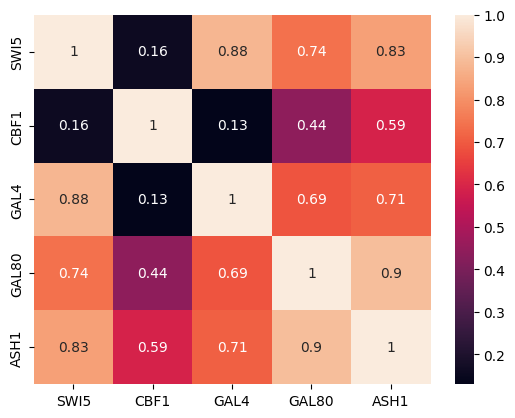

In [5]:
# Print values inside the heatmap

sns.heatmap(corrs, xticklabels=factors.columns, yticklabels=factors.columns, annot=True)

In [39]:
from utils import REF_NET as reference_net
from utils import highlight_edges
from utils import POS

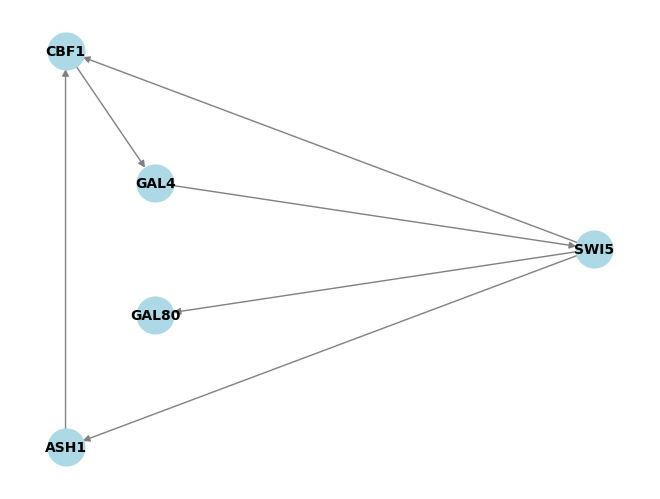

In [40]:
pos = nx.spring_layout(reference_net)
nx.draw(reference_net, POS, with_labels=True, node_size=700, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray')
plt.show()

Threshold: 0.5
[('SWI5', 'GAL4'), ('SWI5', 'GAL80'), ('SWI5', 'ASH1'), ('GAL4', 'GAL80'), ('GAL4', 'ASH1'), ('GAL80', 'ASH1'), ('ASH1', 'CBF1')]
True Positives: 	4 
False Negatives: 	2 
False Positives: 	4 
Precision: 		0.50 
Recall: 		0.67


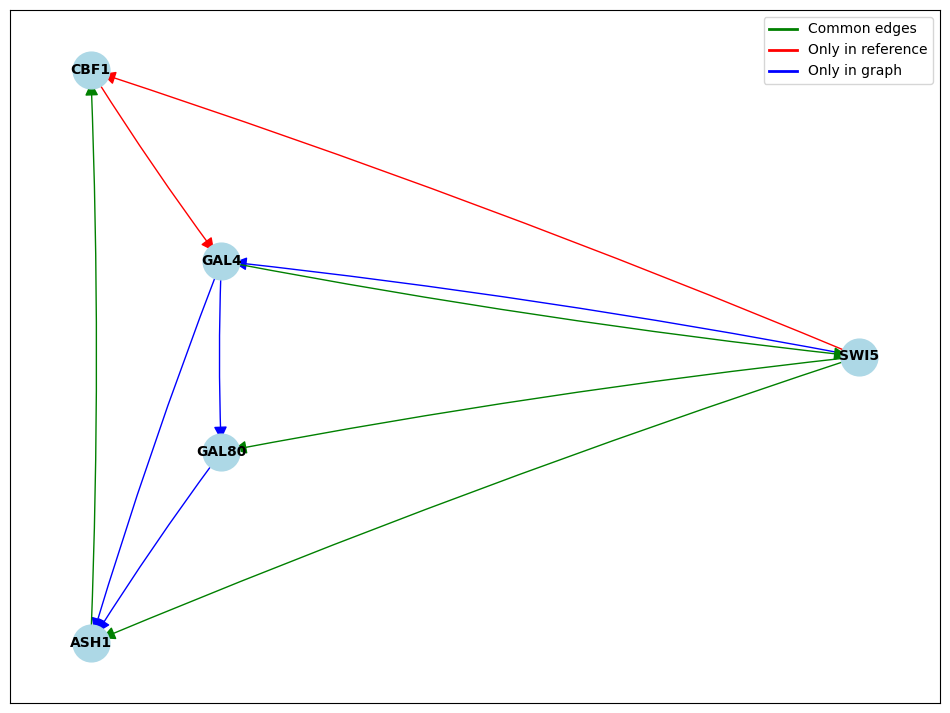

Threshold: 0.5666666666666667
[('SWI5', 'GAL4'), ('SWI5', 'GAL80'), ('SWI5', 'ASH1'), ('GAL4', 'GAL80'), ('GAL4', 'ASH1'), ('GAL80', 'ASH1'), ('ASH1', 'CBF1')]
True Positives: 	4 
False Negatives: 	2 
False Positives: 	4 
Precision: 		0.50 
Recall: 		0.67


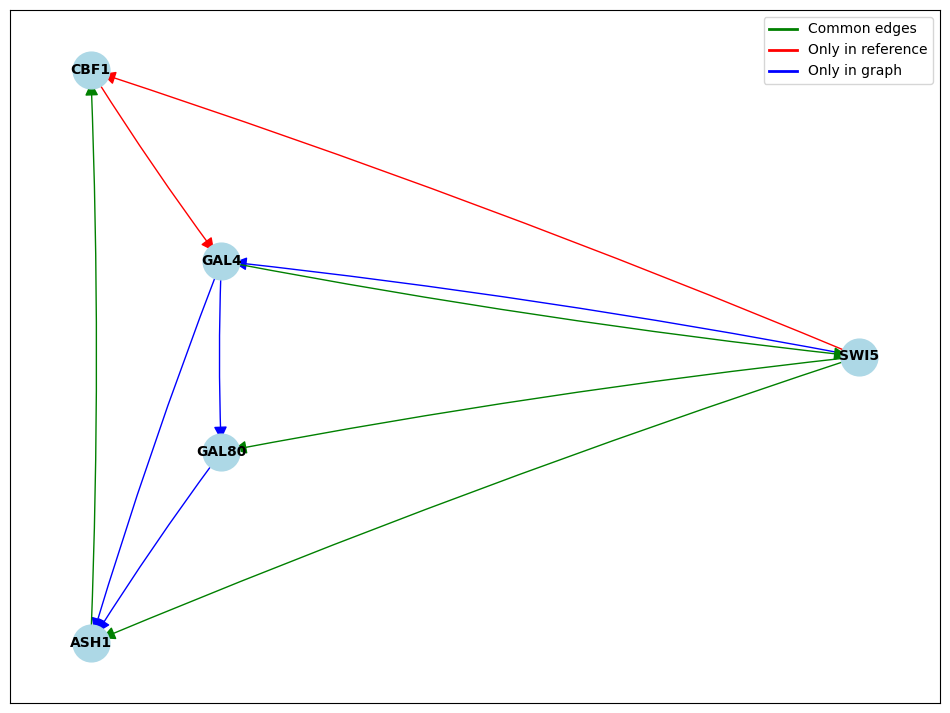

Threshold: 0.6333333333333333
[('SWI5', 'GAL4'), ('SWI5', 'GAL80'), ('SWI5', 'ASH1'), ('GAL4', 'GAL80'), ('GAL4', 'ASH1'), ('GAL80', 'ASH1')]
True Positives: 	3 
False Negatives: 	3 
False Positives: 	4 
Precision: 		0.43 
Recall: 		0.50


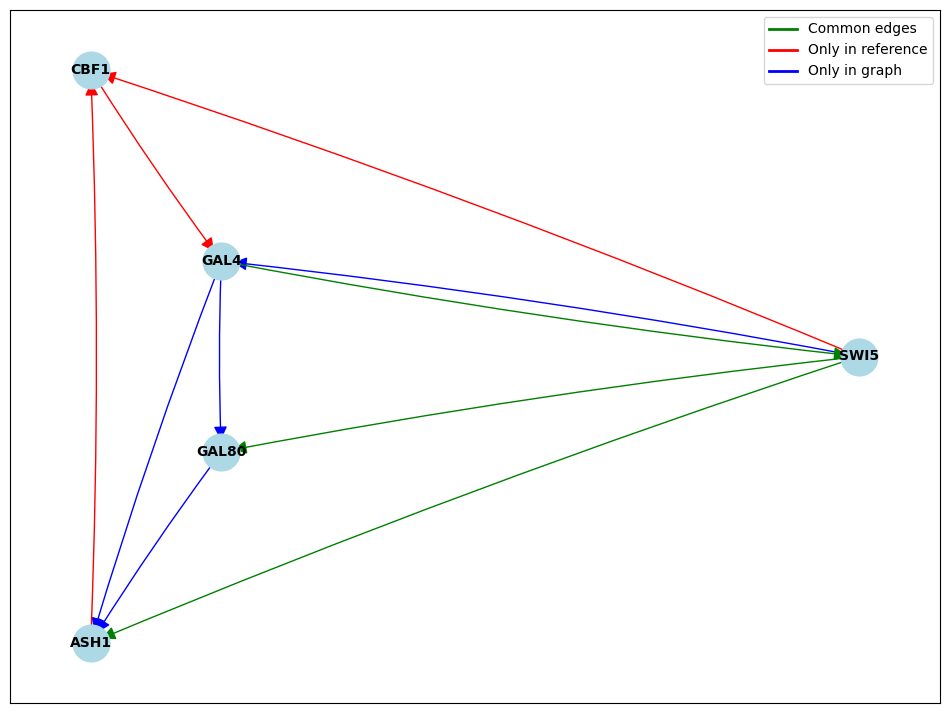

Threshold: 0.7
[('SWI5', 'GAL4'), ('SWI5', 'GAL80'), ('SWI5', 'ASH1'), ('GAL4', 'ASH1'), ('GAL80', 'ASH1')]
True Positives: 	3 
False Negatives: 	3 
False Positives: 	3 
Precision: 		0.50 
Recall: 		0.50


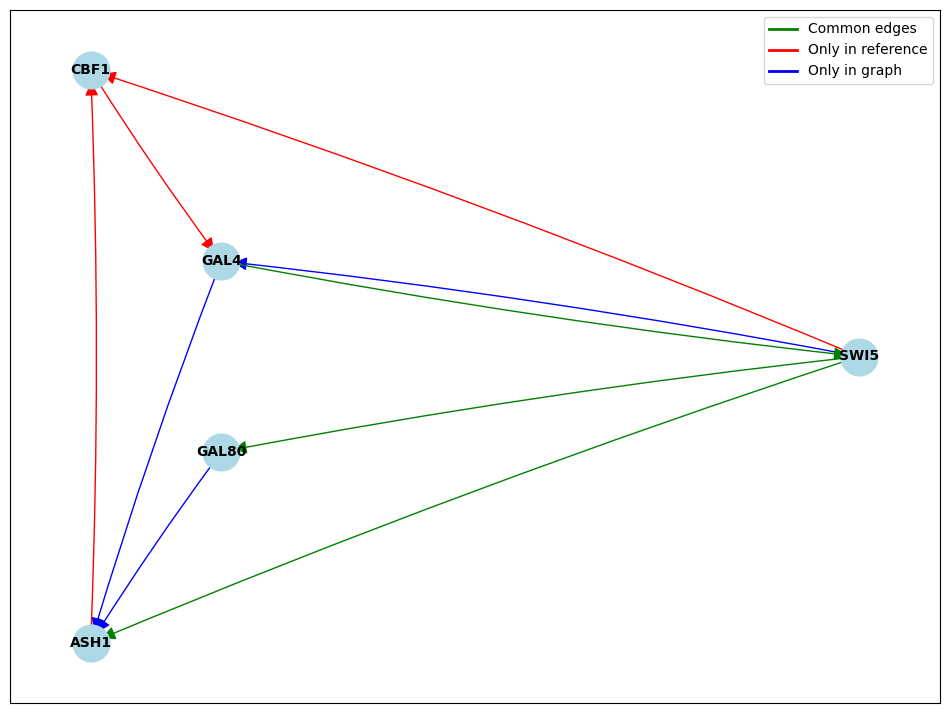

Threshold: 0.7666666666666666
[('SWI5', 'GAL4'), ('SWI5', 'ASH1'), ('ASH1', 'GAL80')]
True Positives: 	2 
False Negatives: 	4 
False Positives: 	2 
Precision: 		0.50 
Recall: 		0.33


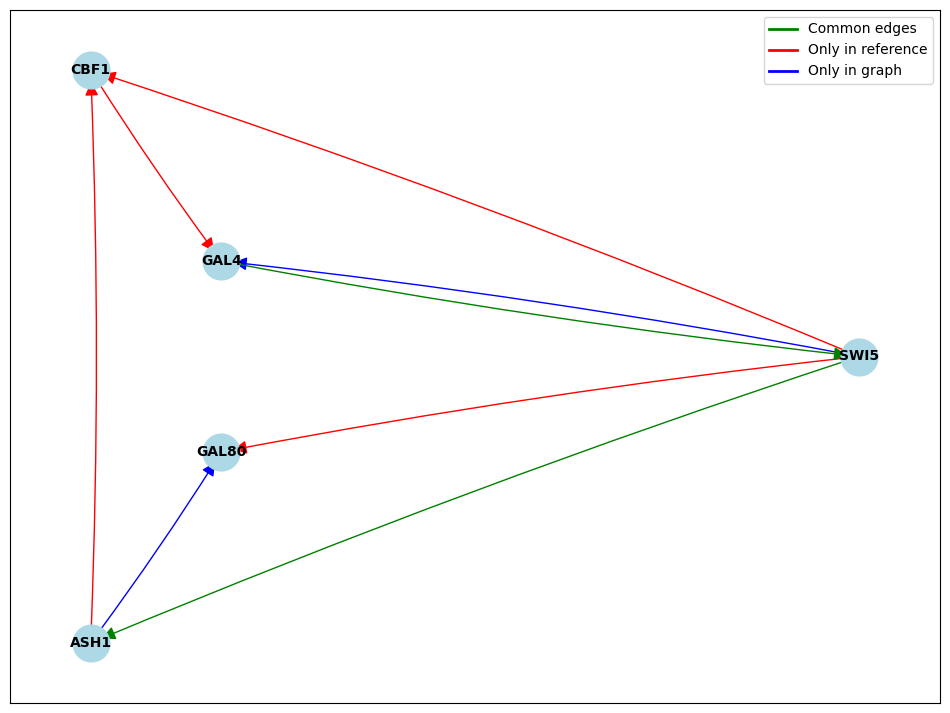

Threshold: 0.8333333333333333
[('SWI5', 'GAL4'), ('GAL80', 'ASH1')]
True Positives: 	1 
False Negatives: 	5 
False Positives: 	2 
Precision: 		0.33 
Recall: 		0.17


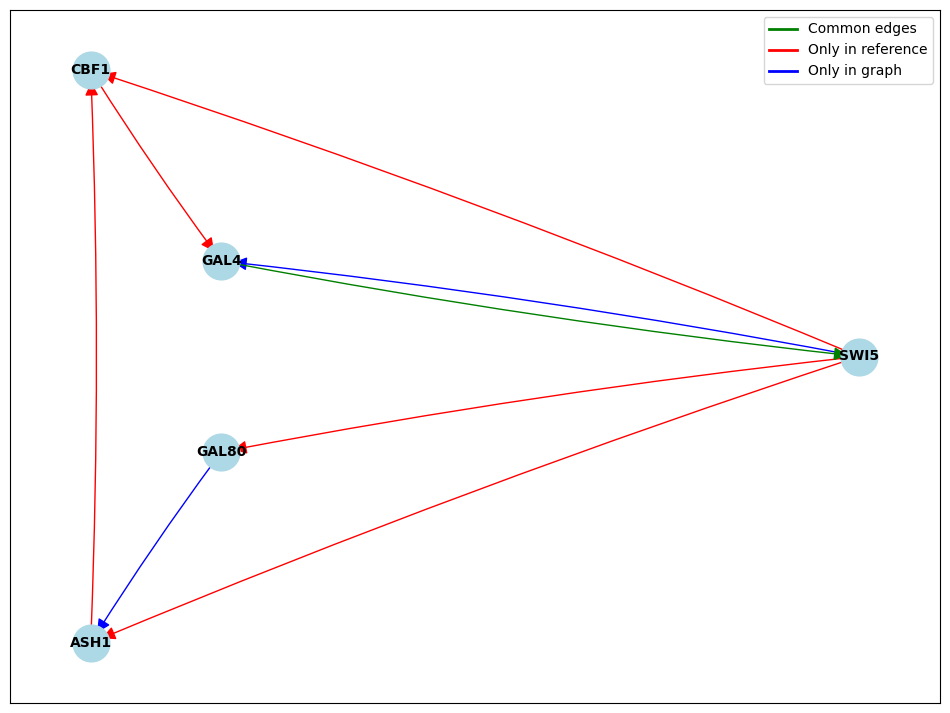

Threshold: 0.9
[]
True Positives: 	0 
False Negatives: 	6 
False Positives: 	0 
Precision: 		0.00 
Recall: 		0.00


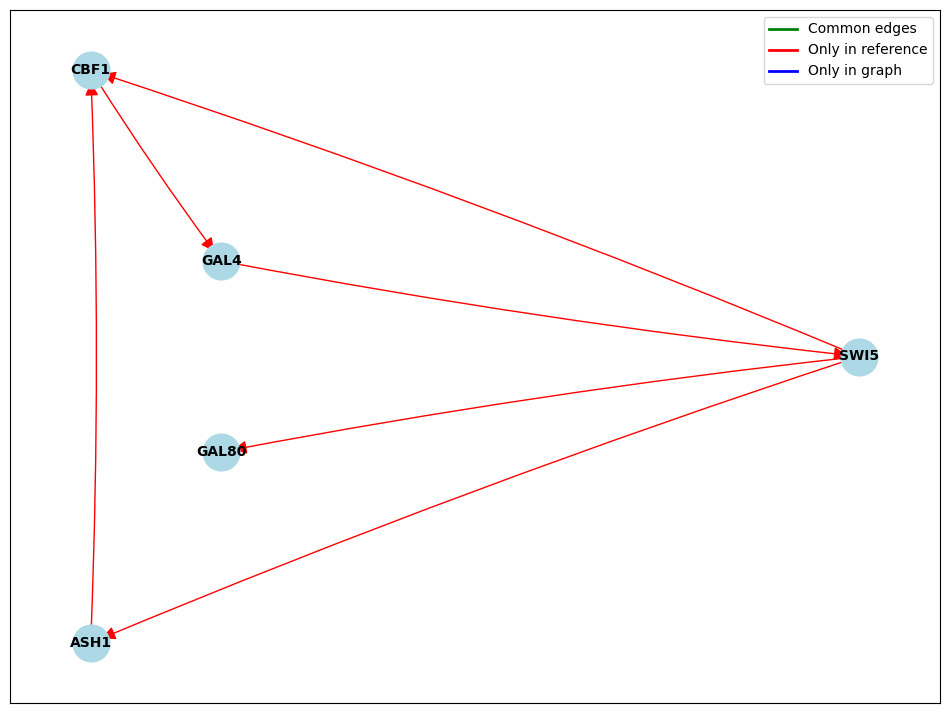

In [41]:
thresholds = np.linspace(0.5, 0.9, num=7)
for threshold in thresholds:
    print(f"Threshold: {threshold}")
    edges = np.where(np.abs(corrs) >= threshold)
    edge_list = [(factors.columns[i], factors.columns[j], corrs[i, j]) for i, j in zip(*edges) if i != j and i < j]
    g = nx.Graph()
    g.add_weighted_edges_from(edge_list)
    # Plot the network
    print(g.edges)
    highlight_edges(g, reference_net)

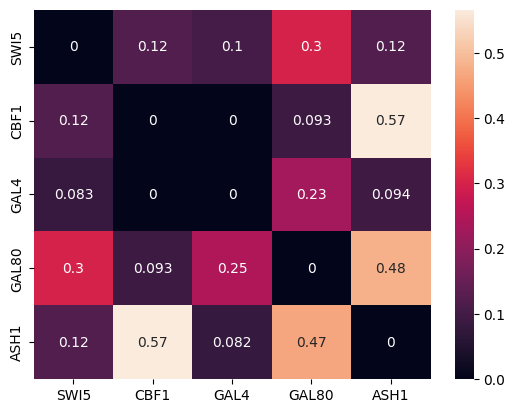

In [42]:
mi_matrix = pd.DataFrame(index=factors.columns, columns=factors.columns)

for i in factors.columns:
    for j in factors.columns:
        if i != j:
            mi = mutual_info_regression(factors[[i]], factors[j])
            mi_matrix.loc[i, j] = mi[0]
        else:
            mi_matrix.loc[i, j] = 0
sns.heatmap(mi_matrix.astype(float), xticklabels=factors.columns, yticklabels=factors.columns, annot=True)
plt.show()

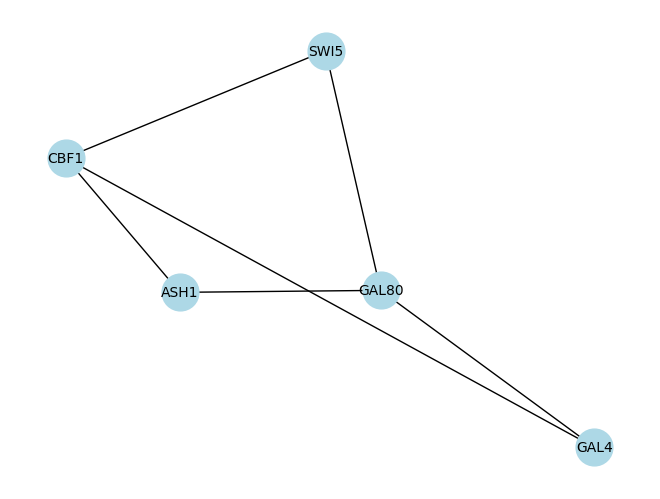

In [43]:
# Aracne algorithm
threshold = 0.1
aracne_edges = []
for i in factors.columns:
    for j in factors.columns:
        if i != j:
            mi_ij = mi_matrix.loc[i, j]
            is_indirect = False
            for k in factors.columns:
                if k != i and k != j:
                    mi_ik = mi_matrix.loc[i, k]
                    mi_jk = mi_matrix.loc[j, k]
                    if mi_ij < min(mi_ik, mi_jk) - threshold:
                        is_indirect = True
                        break
            if not is_indirect:
                aracne_edges.append((i, j, mi_ij))
aracne_net = nx.Graph()
aracne_net.add_weighted_edges_from(aracne_edges)
pos = nx.spring_layout(aracne_net)
nx.draw(aracne_net, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10)
plt.show()

True Positives: 	4 
False Negatives: 	2 
False Positives: 	3 
Precision: 		0.57 
Recall: 		0.67


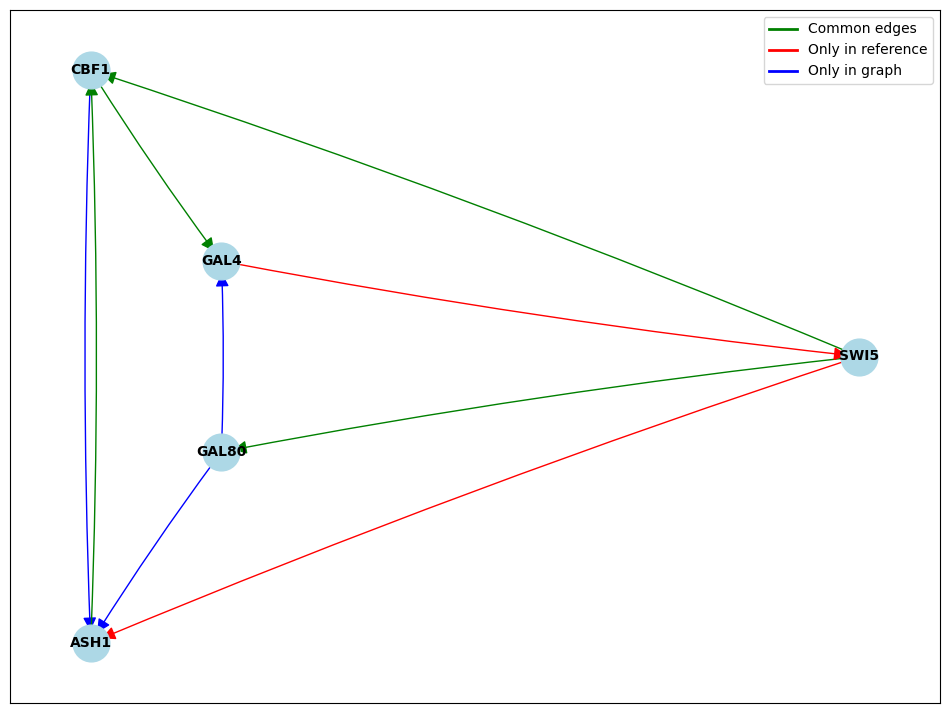

In [44]:
highlight_edges(aracne_net, reference_net)

## Bayesian networks

In [45]:
factors_discretized = factors.copy()
for col in factors_discretized.columns:
    factors_discretized[col] = pd.qcut(factors_discretized[col], q=6, labels=False, duplicates='drop')

In [46]:
from pgmpy.estimators import HillClimbSearch, ExhaustiveSearch
from pgmpy.base import DAG

In [47]:
est = HillClimbSearch(factors)
best_model = est.estimate(scoring_method='bic-g')

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'SWI5': 'N', 'CBF1': 'N', 'GAL4': 'N', 'GAL80': 'N', 'ASH1': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'SWI5': 'N', 'CBF1': 'N', 'GAL4': 'N', 'GAL80': 'N', 'ASH1': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'SWI5': 'N', 'CBF1': 'N', 'GAL4': 'N', 'GAL80': 'N', 'ASH1': 'N'}
  0%|          | 7/1000000 [00:00<8:26:32, 32.90it/s] 


In [48]:
net = nx.DiGraph()
net.add_edges_from(best_model.edges())

True Positives: 	5 
False Negatives: 	1 
False Positives: 	2 
Precision: 		0.71 
Recall: 		0.83


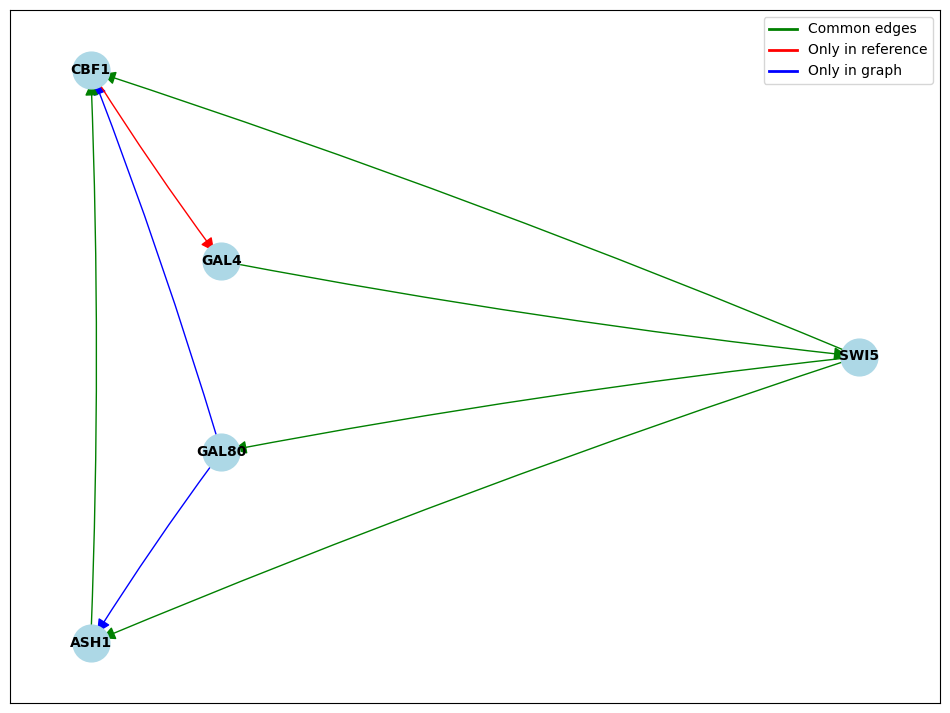

In [49]:
highlight_edges(net, reference_net)

## Gaussian nets

In [50]:
from pgmpy.models import LinearGaussianBayesianNetwork as LGBN
from pgmpy.metrics.metrics import log_likelihood_score
from pgmpy.metrics.bn_inference import BayesianModelProbability
from PIL import Image
import random

In [51]:
model = LGBN(aracne_net.edges())
model.fit(factors)

In [52]:
def plot_predicted_vs_actual(model, data, factors, title=''):
    # Plot predicted vs actual for each variable
    fig, ax = plt.subplots(3, 2, figsize=(15, 10))
    ax_flat = ax.ravel()

    for idx, var in enumerate(factors.columns):
        variables, mu, cov = model.predict(factors.drop(columns=[var]))
        x = data['time']
        max_val = factors[var].max()
        max_val = max_val + 0.7 * abs(max_val)
        min_val = factors[var].min()
        min_val = min_val - 0.7 * abs(max_val)
        ax_flat[idx].plot(x, factors[var], label='Actual')
        ax_flat[idx].plot(x, mu.ravel(), label='Predicted')
        # Plot 95% confidence interval
        std = np.sqrt(cov).ravel()
        ax_flat[idx].fill_between(x, (mu.ravel() - 1.96 * std), (mu.ravel() + 1.96 * std), color='gray', alpha=0.5, label='95% CI')
        ax_flat[idx].set_ylim([min_val, max_val])
        ax_flat[idx].set_title(f'Predicted vs Actual for {var} {title}')
        ax_flat[idx].set_xlabel('Time')
        ax_flat[idx].set_ylabel(var)
        ax_flat[idx].grid()
        ax_flat[idx].legend()
    plt.tight_layout()
    plt.show()

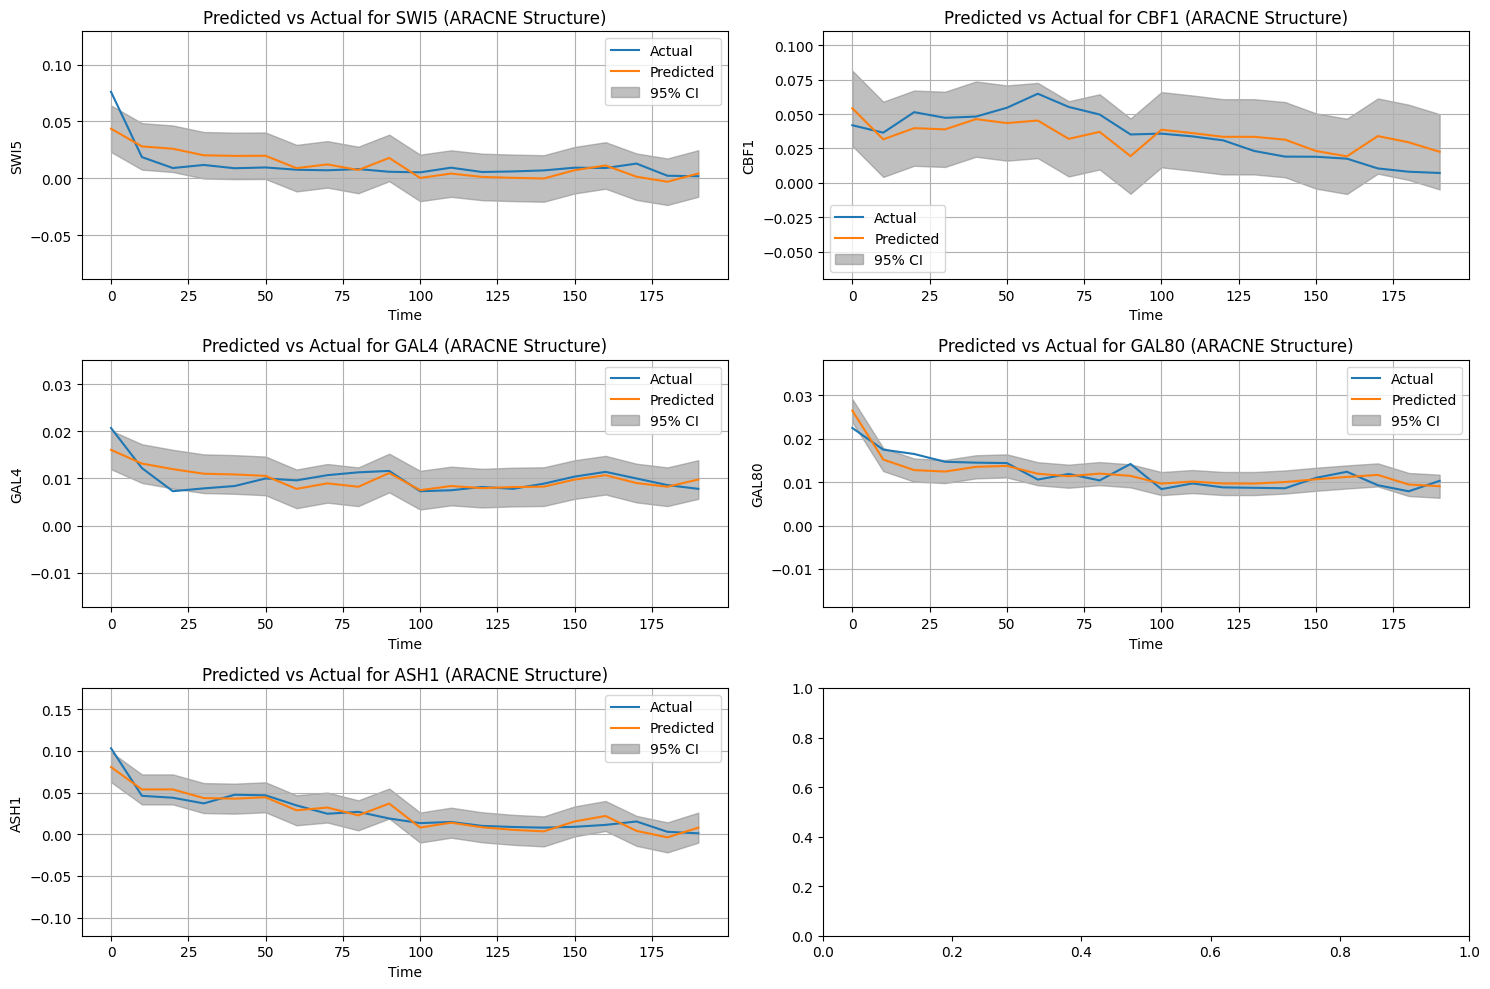

In [53]:
plot_predicted_vs_actual(model, data, factors, title='(ARACNE Structure)')

In [54]:
model.get_cpds()

[<LinearGaussianCPD: P(SWI5) = N(0.012; 0.0) at 0x7f0aa883b710,
 <LinearGaussianCPD: P(CBF1 | SWI5) = N(0.174*SWI5 + 0.033; 0.0) at 0x7f0aa8839d90,
 <LinearGaussianCPD: P(GAL80 | SWI5) = N(0.178*SWI5 + 0.01; 0.0) at 0x7f0aa862d0d0,
 <LinearGaussianCPD: P(GAL4 | CBF1, GAL80) = N(-0.038*CBF1 + 0.623*GAL80 + 0.004; 0.0) at 0x7f0aa862d860,
 <LinearGaussianCPD: P(ASH1 | CBF1, GAL80) = N(0.336*CBF1 + 5.003*GAL80 + -0.046; 0.0) at 0x7f0aa80762b0]

True Positives: 	4 
False Negatives: 	2 
False Positives: 	3 
Precision: 		0.57 
Recall: 		0.67


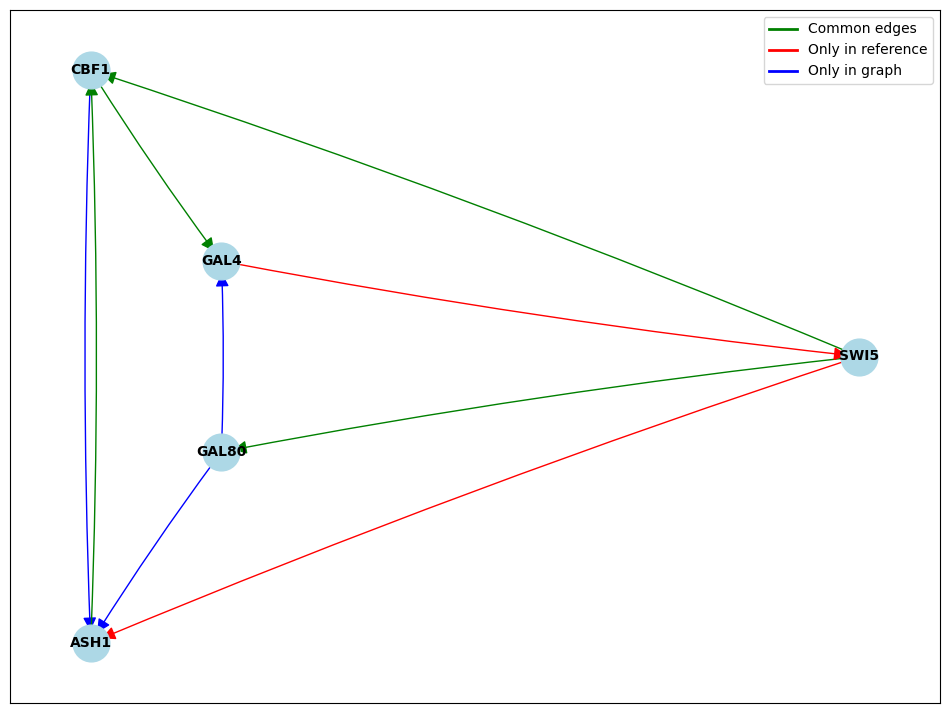

In [55]:
highlight_edges(aracne_net, reference_net)

In [56]:
def deloop(net):
    flag = True
    while flag:
        try:
            edges = nx.find_cycle(net)
            # Remove a random edge from the cycle
            edge_to_remove = random.choice(edges)
            net.remove_edge(*edge_to_remove)
        except nx.exception.NetworkXNoCycle:
            flag = False
            pass
    return net

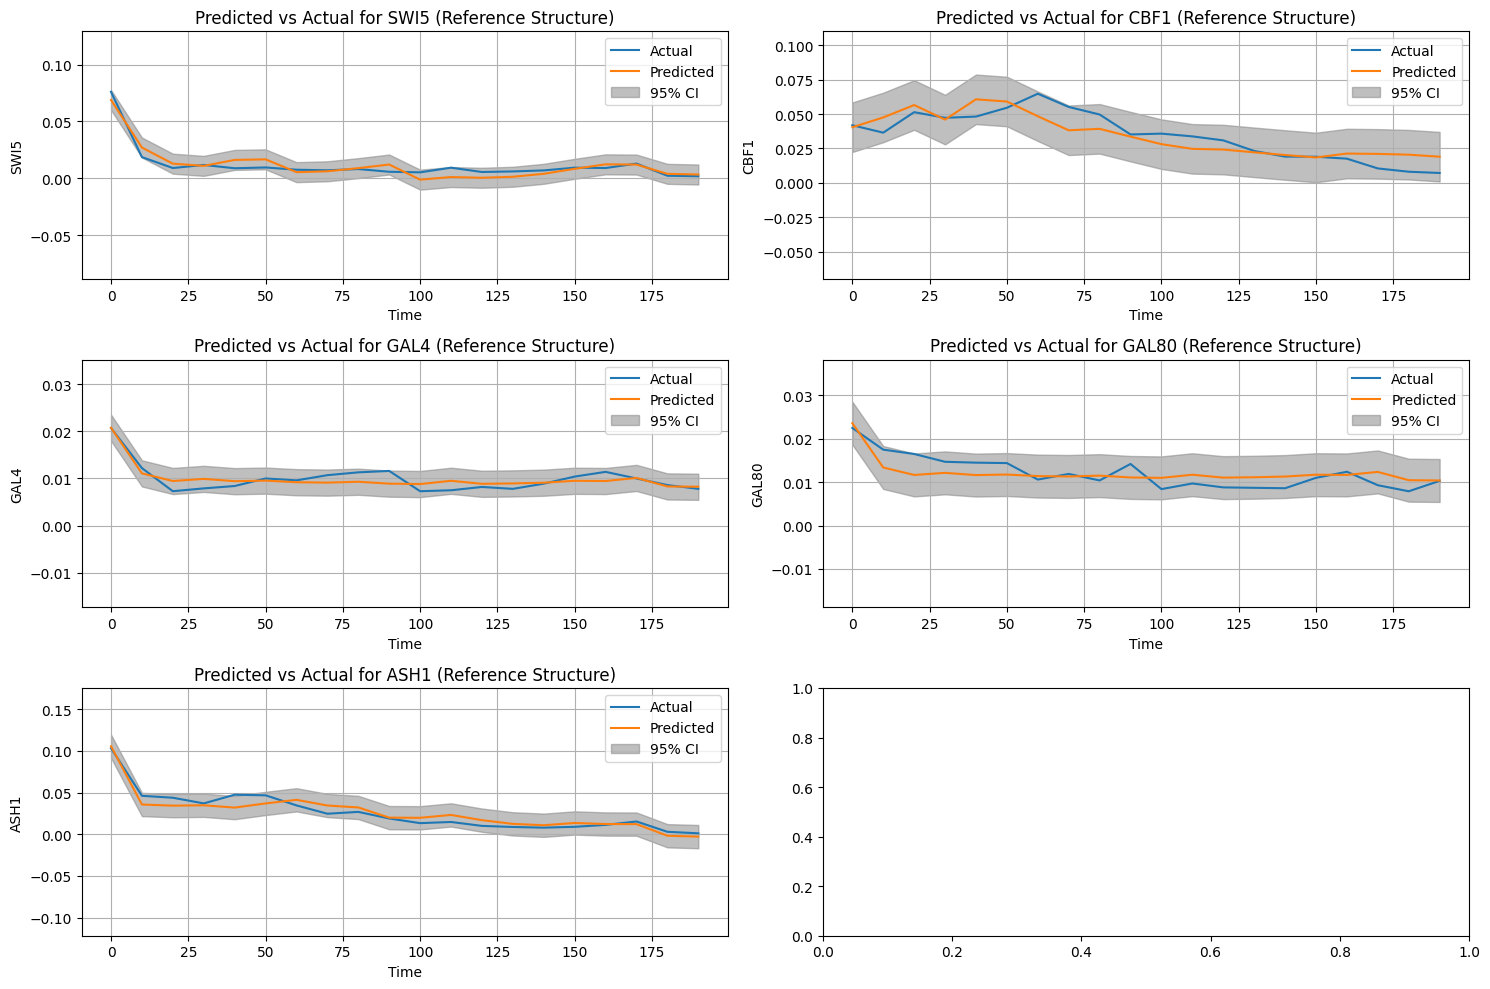

In [57]:
reference_net_delooped = deloop(reference_net.copy())
model = LGBN(reference_net_delooped.edges())
model.fit(factors)
plot_predicted_vs_actual(model, data, factors, title='(Reference Structure)')

True Positives: 	5 
False Negatives: 	1 
False Positives: 	0 
Precision: 		1.00 
Recall: 		0.83


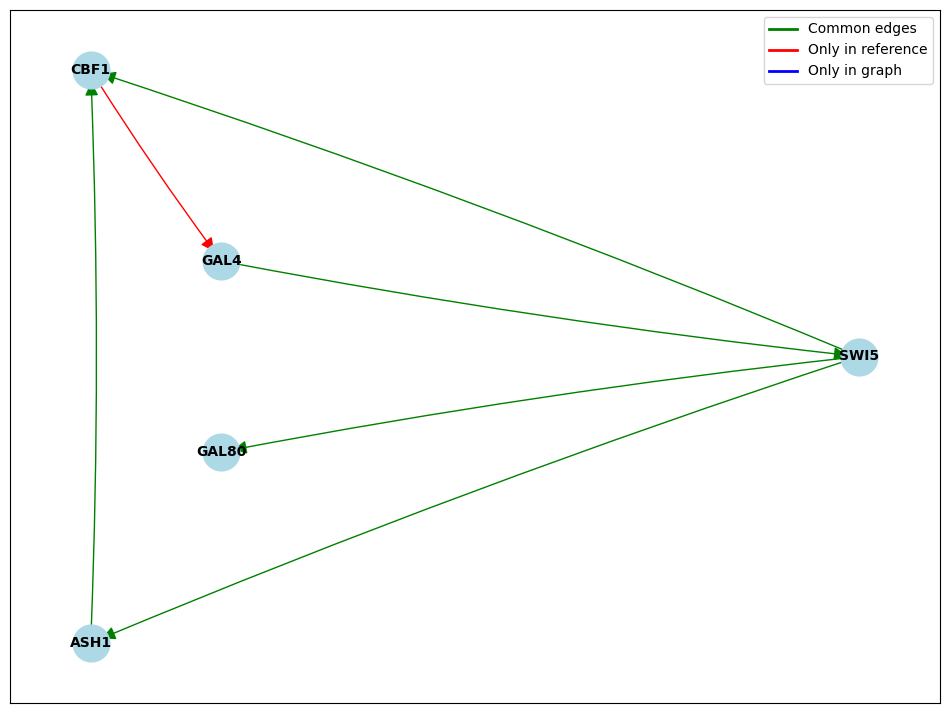

In [58]:
highlight_edges(reference_net_delooped, reference_net)

In [59]:
model.get_cpds()

[<LinearGaussianCPD: P(GAL4) = N(0.01; 0.0) at 0x7f0aa5aaf7f0,
 <LinearGaussianCPD: P(SWI5 | GAL4) = N(4.599*GAL4 + -0.034; 0.0) at 0x7f0aa7e11370,
 <LinearGaussianCPD: P(ASH1 | SWI5) = N(1.27*SWI5 + 0.012; 0.0) at 0x7f0aa7fb1950,
 <LinearGaussianCPD: P(GAL80 | SWI5) = N(0.178*SWI5 + 0.01; 0.0) at 0x7f0aa83d2050,
 <LinearGaussianCPD: P(CBF1 | SWI5, ASH1) = N(-1.201*SWI5 + 1.083*ASH1 + 0.02; 0.0) at 0x7f0aa5c033f0]

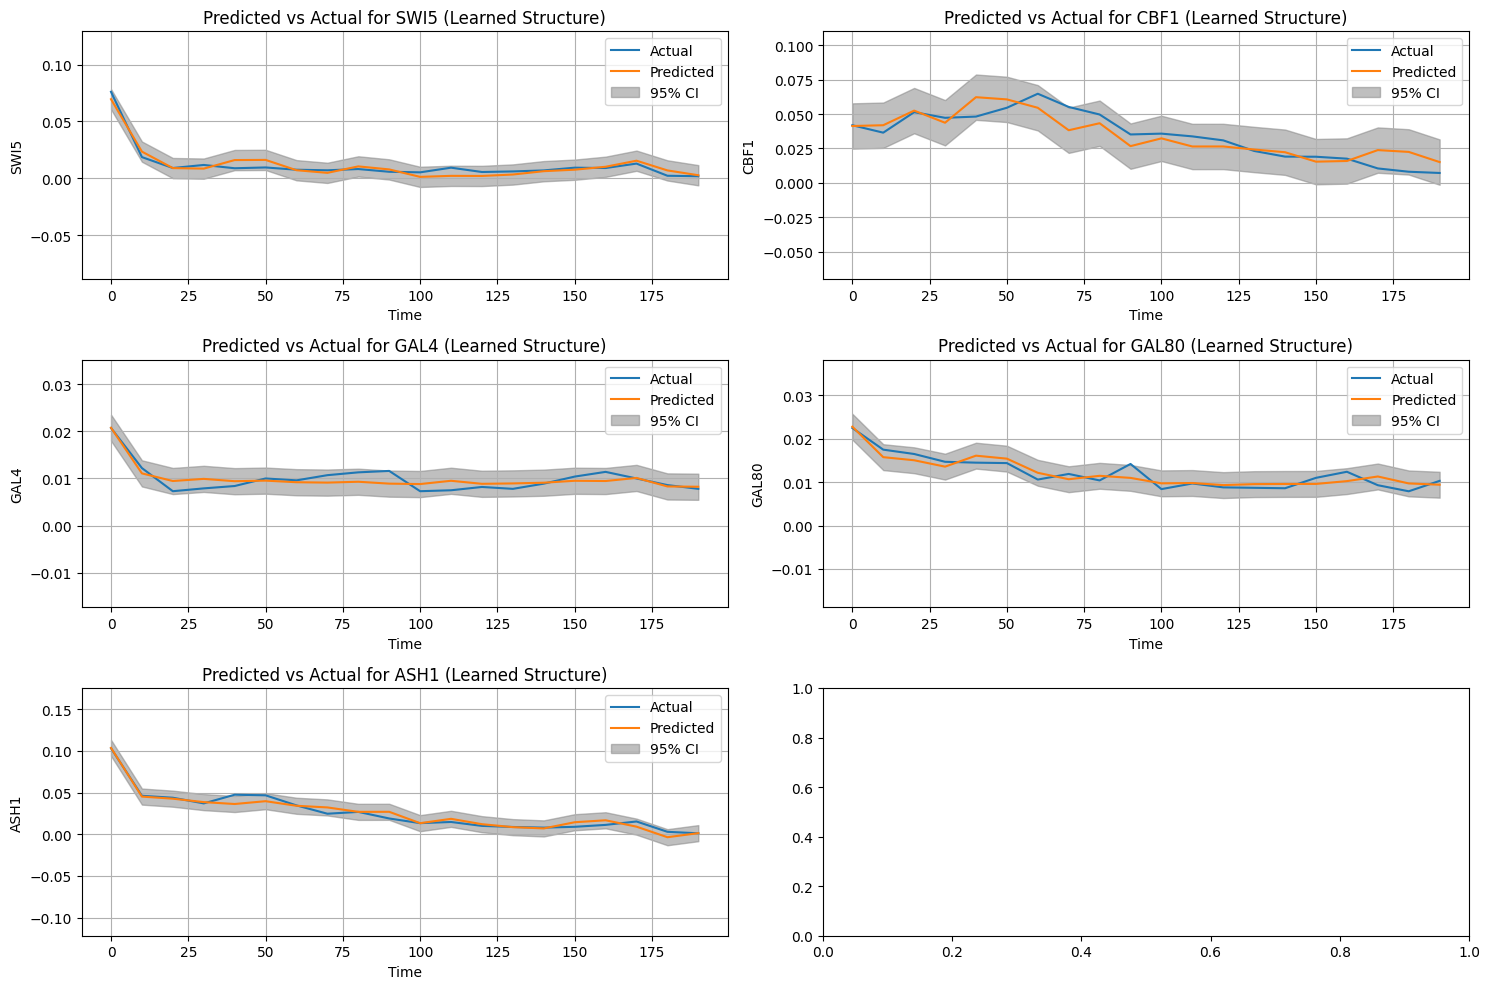

True Positives: 	5 
False Negatives: 	1 
False Positives: 	2 
Precision: 		0.71 
Recall: 		0.83


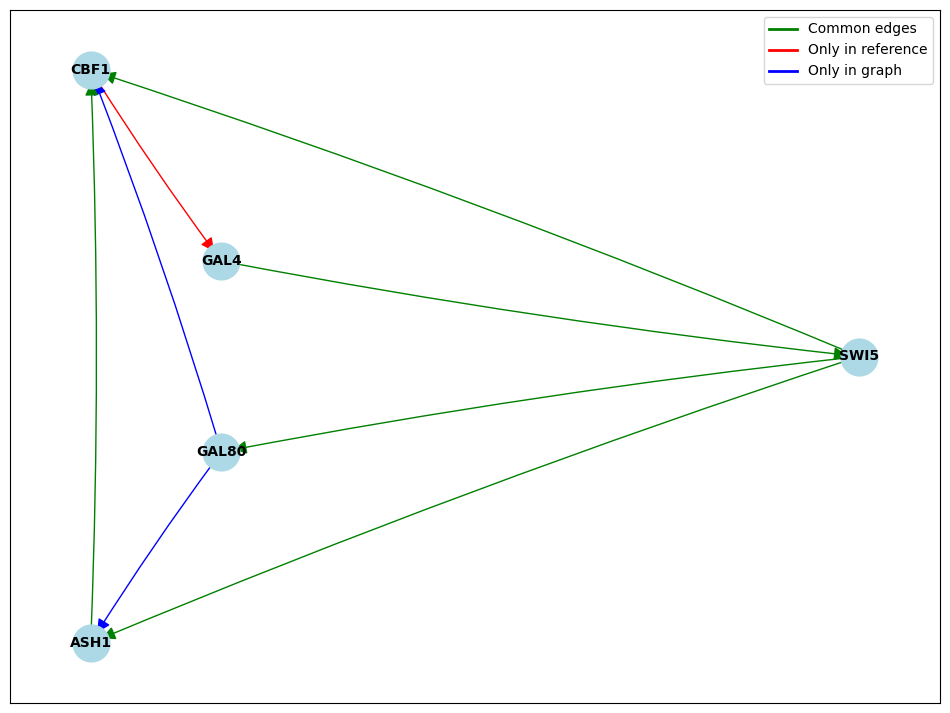

In [61]:
model = LGBN(best_model)
model.fit(factors)
plot_predicted_vs_actual(model, data, factors, title='(Learned Structure)')
highlight_edges(best_model, reference_net)

## Dynamic Bayesian nets


In [62]:
from pgmpy.models import DynamicBayesianNetwork as DBN

factors_timeslices = factors_discretized.copy()
# Convert to categorical type
for col in factors_timeslices.columns:
    factors_timeslices[(col, 0)] = factors_timeslices[col].shift(1)
    factors_timeslices.rename(columns={col: (col, 1)}, inplace=True)
factors_timeslices = factors_timeslices.dropna()

model = DBN([((u, 0), (u, 1)) for u in factors.columns])
model.fit(factors_timeslices,)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'CBF1_0': 'N', 'GAL4_0': 'N', 'ASH1_0': 'N', 'SWI5_0': 'N', 'GAL80_0': 'N', 'CBF1_1': 'N', 'GAL4_1': 'N', 'ASH1_1': 'N', 'SWI5_1': 'N', 'GAL80_1': 'N'}


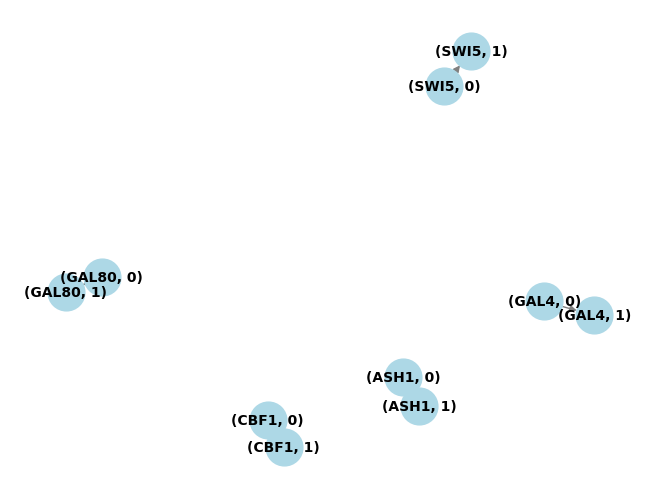

In [63]:
net = nx.DiGraph()
net.add_edges_from(model.edges())
nx.draw(net, with_labels=True, node_size=700, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray')

In [64]:
model.get_cpds()

[<TabularCPD representing P((CBF1, 0):6) at 0x7f0aa5311a30>,
 <TabularCPD representing P((GAL4, 0):6) at 0x7f0aa5311b50>,
 <TabularCPD representing P((ASH1, 0):6) at 0x7f0aa5311d90>,
 <TabularCPD representing P((SWI5, 0):6) at 0x7f0aa5311eb0>,
 <TabularCPD representing P((GAL80, 0):6) at 0x7f0aa5311c70>,
 <TabularCPD representing P((CBF1, 1):6 | (CBF1, 0):6) at 0x7f0aa5311ac0>,
 <TabularCPD representing P((GAL4, 1):6 | (GAL4, 0):6) at 0x7f0aa5311be0>,
 <TabularCPD representing P((ASH1, 1):6 | (ASH1, 0):6) at 0x7f0aa5311e20>,
 <TabularCPD representing P((SWI5, 1):6 | (SWI5, 0):6) at 0x7f0aa5311910>,
 <TabularCPD representing P((GAL80, 1):6 | (GAL80, 0):6) at 0x7f0aa5311d00>]